# COGS 118A - Final Project

# The Price of Beer

## Group members
- Dhathry Doppalapudi | A16298078
- Serina Khanna | A15851279
- Niko Calsada | A15352545

# Abstract 
The goal of our project is to predict beer future beer prices in Russia. This can be used by Russian bars and breweries to help them price their beers. The data used is from a craft beer bar in Russia and has variables such as product name, retail price, size, country of origin, and alcohol by volume (ABV). We will be using the data to understand how these variables affect the price and predict how the price of craft beer will change in the future. Performance will be measured by how low our error metrics such as mean squared error and mean absolute error are.

# Background

Since COVID-19 began to spread in March 2020, supply chain issues for various products have increased and many industries have been affected. Among restaurants, there was a significant labor shortage and home delivery systems became more popular <a name="forbes"></a>[<sup>[5]</sup>](#forbes). While these new options are definitely more popular among consumers, a lack of in-person customers have affected establishments that rely on people buying their products in-person, such as establishments that sell alcohol. In addition, the war in Ukraine and inflation have impacted the alcohol industry, with 20% of the world’s barley coming from Ukraine and beer prices rising slightly<a name="war"></a>[<sup>[1]</sup>](#war). In addition, given that our data is from a Russian bar, it’s possible that our data has been impacted by the Russian-Ukrainian war as many people boycotted Russian alcohol<a name="mccormick"></a>[<sup>[2]</sup>](#mccormick).

We’re interested in training a machine learning model to predict craft beer prices based on data directly from a bar located in Russia. There have been studies on beer prices<a name="beeralytics"></a>[<sup>[3]</sup>](#beeralytics), but none that have attempted to predict beer prices themselves. There have also been models trained on predicting beer quality<a name="jeevan"></a>[<sup>[4]</sup>](#jeevan)., which predicts the quality of a beer using ratings from the Tastings website, alcohol content, kind of alcohol, price, country of origin, and style/flavor. While many of these quantities overlap with our project, we won’t be training our model on opinion-based data.

Our trained model can be important for Russian bars to learn how to price their beers, or for brands to be able to predict a good price for a new beer.


# Problem Statement

In our project, we aim to solve the problem of predicting the future prices of different types of craft beer in Russia. The majority of variables we will analyze in this project, such as ABV (percentage), volume (mL), number of units sold, and discounted prices are quantitative metrics, which will allow us to predict the future price (in Russian rubles) mathematically. We are implementing multiple linear regression to predict the beer prices based on the multiple independent variables we have in our data. After this, our model can be used by beer manufacturers to determine the reasonable price to set their beer or by bars to determine when to purchase beer.

# Data

Dataset 1: https://www.kaggle.com/datasets/podsyp/sales-in-craft-beer-bar?select=Product_range.csv

Dataset 2: https://www.kaggle.com/datasets/podsyp/sales-in-craft-beer-bar?select=Transactions.csv

Our dataset contains information regarding Nelson Sauvin Bar sales history. Nelson Sauvin Bar is a Russian establishment founded in the spring of 2016. Their inventory contains a wide variety of domestic Russian beers and imported beers from other European countries and the USA. We have obtained two different data sets regarding Nelson Sauvin’s product range and their transaction history. In this project, we will specifically be looking at their transaction history from January 2020 to September 2022.

The first dataset regarding product range contains 5314 observations listed as product codes. For each code, there are 8 associated variables describing the following features: product code, country of origin, vendor code, name of product, ABU, size, retail price, and base unit. The critical variables we focus on are product code, ABU (%), retail price (rubles), and size (L).

The second dataset, our transaction history dataset contains 50084 observations which represent the date and times of register unloadings. Each unloading has the following 7 features: product code, amount of units sold, sale amounts, discount amount, profit, discount percentage, and percentage markup. The variables we focus on are product code, amount (rubles), and sale amount (rubles).

We clean both datasets individually by removing unimportant variables and any rows with null values. We also convert any values needed to be floats and reset the index. We then merge both datasets together based on product code. 

Additionally, since our project is only concerned with this bar in Russia, there is no conversion of any currency over to the USD. All values of currency will remain in rubles.



# Proposed Solution

Because this is a regression problem, we are going to attempt to use multiple linear regression to train our model. Multiple linear regression allows us to predict continuous values (like the price of beer) when considering multiple independent variables (manufacturer, SKU, country of origin, SKU size, and alcohol by volume). Other models that could work include regular Linear Regression, polynomial regression for a polynomial relationship, or decision tree regression (which would be better suited with less independent variables).

The libraries we will use are numpy, sklearn, and pandas.
- Clean data of missing values, NaN, and variables that we won’t be considering
- Check correlation of data via multiple scatter plots
- Split data into test/train set
- Formulate Multiple Linear Regression model
- Fit model to train data, test model on testing data
- Use Ordinary Least Squares to minimize the residual

If we see that the relationship between any of the independent variables and the price is different than expected, or if any assumptions surrounding linear regression are broken, we will consider changing our model to another one. To make our results more accurate, we will also experiment with different kinds of regularization (OLS, L1, L2, Lasso) and different regularization strengths.


# Evaluation Metrics

We are using the Mean Squared Error (MSE) to find the average difference between the actual and predicted values for craft beer prices, as it is the standard with Ordinary Least Squares.

The equation for Mean Squared Error is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/ae01f23f2ed2814c7db94e1fdc952732f5ca533a)

where given a vector of $n$ observations from a sample taken from $n$ data points on all independent variables, with $Y$ being the observed values being predicted and $\hat{Y}$ being the predicted values.


# Results

### Multiple Linear Regression (MLR)

We determined it to be necessary to run multiple linear regression on our data because we firstly wanted a model that could predict the price of beer, hence linear regression seemed like a good fit. In this case, our response variable that we wished to predict is the price of the product, and the independent variables that we are monitoring are ABV, sale price, amount, and size. Since there are multiple independent variables, multiple linear regression was found to be the best model that we could start with. 

In addition, when considering the principle of parsimony analysis, multiple linear regression seemed like the simplest model that would work.

### MLR of product_range.csv

Please read more about our analysis [here](results/ProductRangeAnalysis.ipynb).

The product_range.csv file describes every product offered by this Russian bar, with variables including: product code, country of origin, vendor code, name of product, ABV, size, retail price, and base unit. We removed categorical variables (country of origin) because there were 20+ countries previously present, and one-hot encoding for all of these countries proved to be a lot of data to work with. We narrowed down to analyzing variables that we believe could influence price, including ABV, size (base unit describes the size in language familiar to the restaurant, while size contains the size in Liters), and retail price.

After cleaning the data, we found 3500+ observations to chose from - not a strong number. We plotted a heatmap of the remaining variables and found that none had a strong correlation with each other.

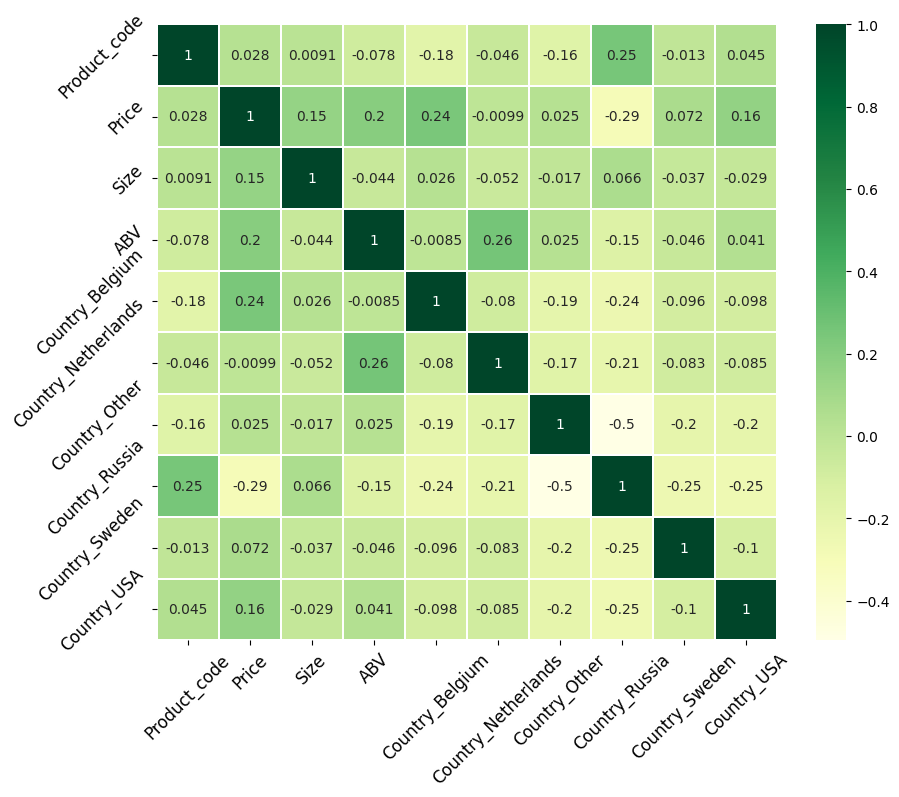

We ran multiple linear regression on this dataset using an 80% test and a 20% split set, and created a scatterplot demonstrating the predicted labels being compared to the actual labels. Our mulitple linear regression had a score of 193078.50, which wasn't a good score.

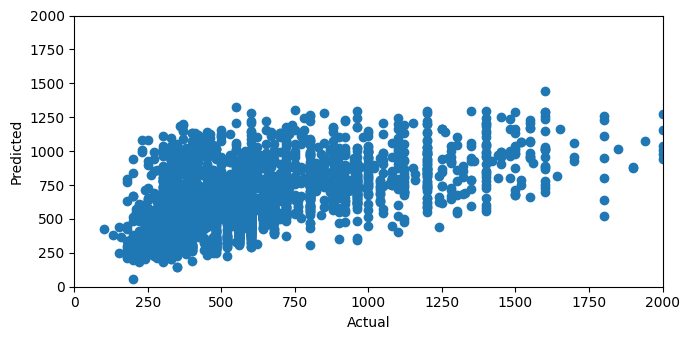

Finally, we plotted the relationship between ABV, size, and price via a 3D plot.

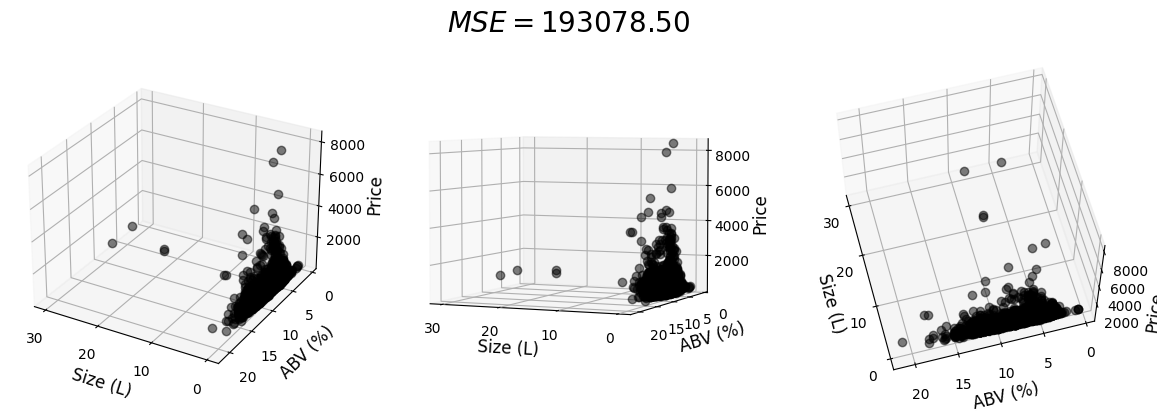

### MLR of transactions.csv

Please read our analysis [here](results/TransactionsAnalysis.ipynb).

Our second dataset was the transactions.csv dataset, which describes transactions from January 2020 to September 2022 within the bar. The variables it includes are: product code, amount of units sold, sale amounts, discount amount, profit, discount percentage, and percentage markup. We only kept product code, amount (rubles), and sale amount (rubles), as the remaining variables were not independent of each other. 

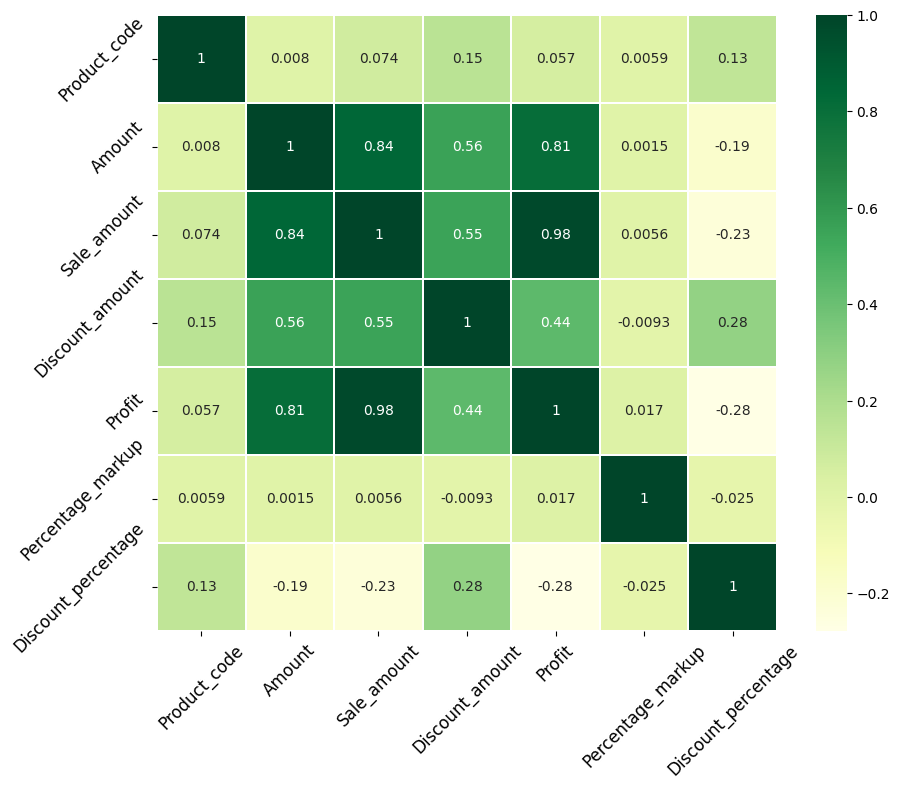

We ran multiple linear regression on this dataset using an 80% test and a 20% split set, and created a scatterplot demonstrating the predicted labels being compared to the actual labels, in regards to sale amount and with outliers > 2000 removed. 

Our independent variables were the amount, discount amount, profit, percentage markup, discount percentage, and we attempted to predict the sale amount, since the transactions dataset does not contain a "profit" column.

Our MSE reduced to 166,000+, which is still a score that can be improved, but is definitely better! Let's check out a plot of the actual results vs the predicted results.

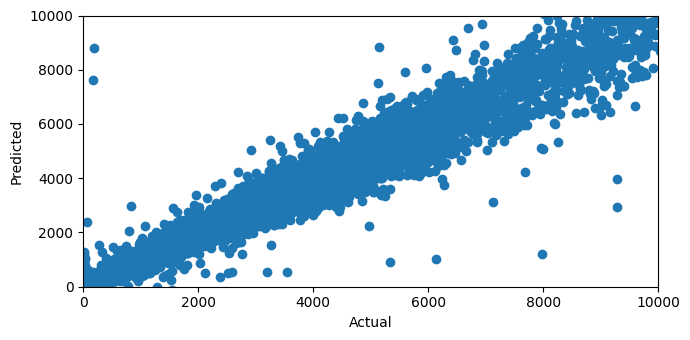

### MLR on Merged Dataset

Please read our analysis [here](results/Merged.ipynb).

With having analyzed both of our datasets separately, we merged them together to see if their MSE would improve together 
Our merged dataset has almost 30,000 observations - that's definitely a lot of data that our model can learn from.

Our merged dataset now contains the following variables: the product code, vendor, name of drink, price, size, ABV, one-hot-encoded for country of origin, sale amount, discount amount, profit, percentage markup, discount percentage, and date of transaction. That's a lot of data! We run a heatmap to see any potential correlations.

 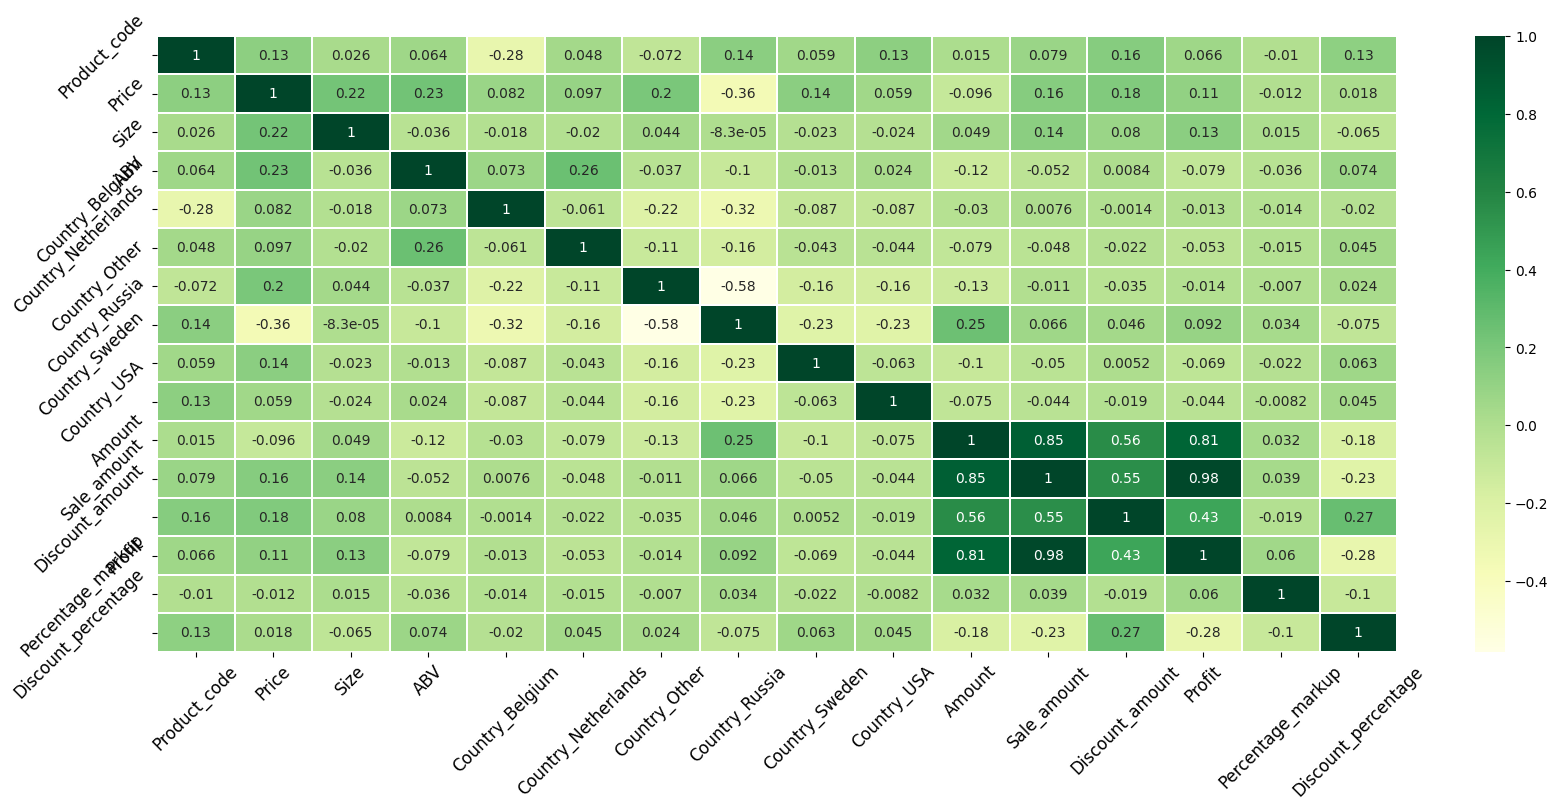


For now, we'll be selective about what columns we want to analyze, and run Multiple Linear Regression to predict the price (rubles).

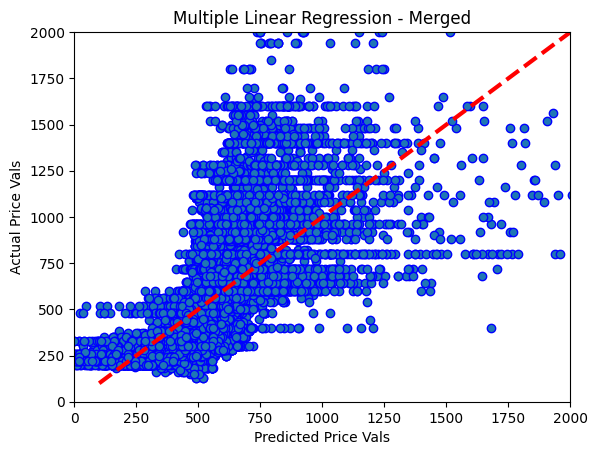

Our MSE was 91657, a score that has definitely improved greatly, but is still not a reliable model. Our chart above doesn't look the most accurate either.

### Random Forest

Please read our analysis [here](results/RandomForest.ipynb).

Now, we attempted Random Forest to see if another model may be able to accurately predict a relationship from our data. Random Forest is a model that is well equiped for large datasets and may provide a higher accuracy measure for us. It's possible that some variables may not be as important as others, and Random Forest may be able to find these relationships better.

Our results were:

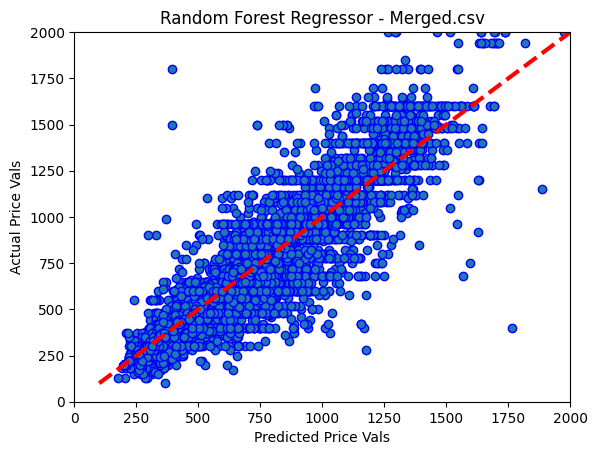

And our MSE was an improved 35088, which is better but still not a good score overall.

# Discussion

### Interpreting the result

There may not be a relationship between any of the independent variables we analyzed (the product code, vendor, name of drink, price, size, ABV, one-hot-encoded for country of origin, sale amount, discount amount, profit, percentage markup, discount percentage, and date of transaction) and the dependent variable of price OR there may be a non-linear relationship describing the price of beer with various independent variables.

Firstly, we found little evidence of many significant relationships we found linearly with any of our independent variables and our dependent variables. We plotted several heatmaps, notably in our analysis of product_range.csv, transactions.csv, and our merged dataset, and found no significant relationship between any independent variables that we did not previous know about. It should be noted that relationships between sale amount and amount are to be expected, and additional relationships between the price variables (price, sale amount, discount amount, profit, percentage markup, discount percentage) are known to exist.

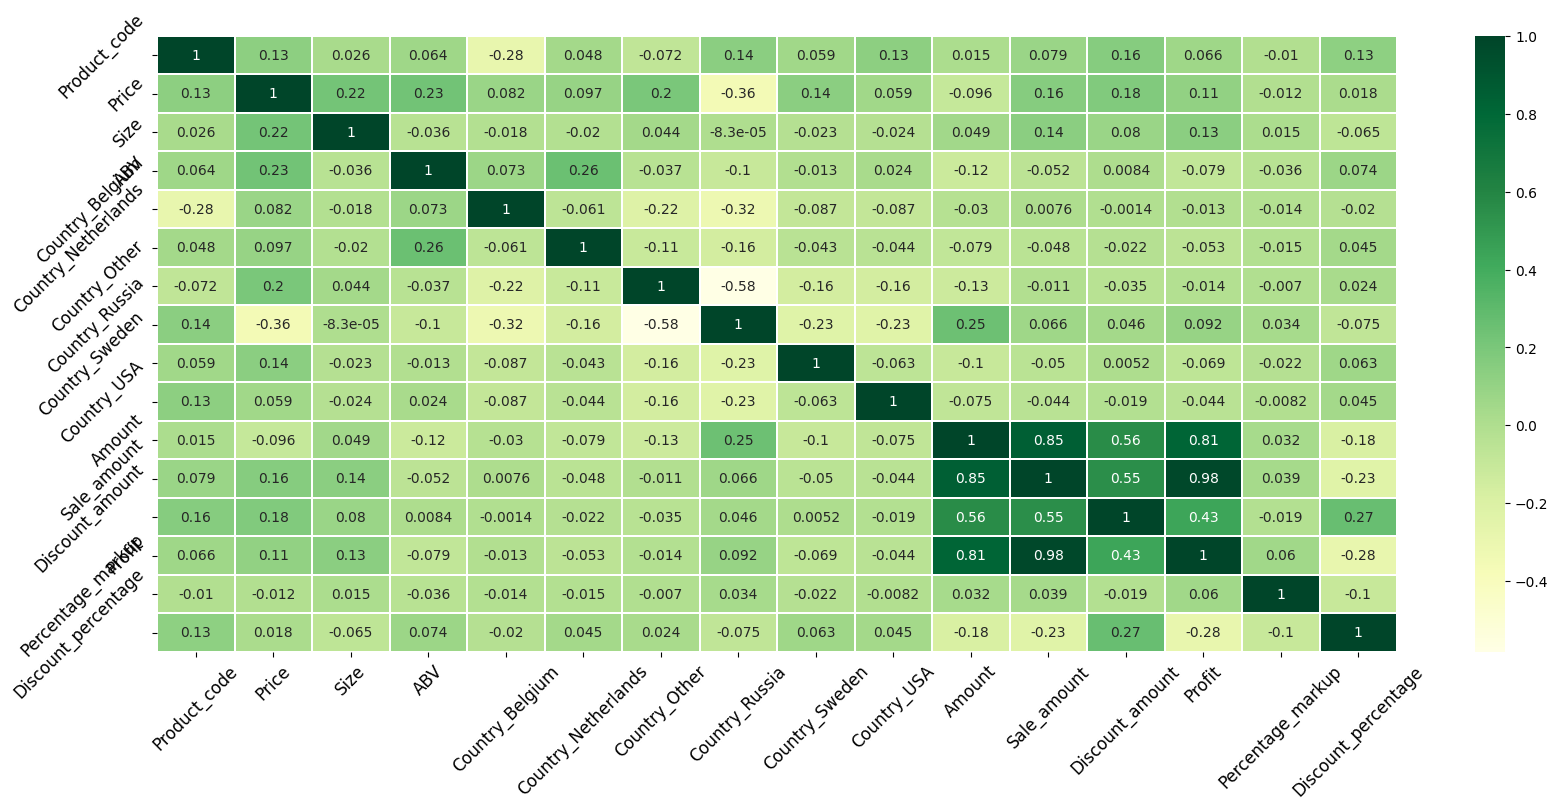

Secondly, we found that neither linear regression nor random forest regression resulted in an accurate model given our data. We may need a more complex, non-linear algorithm in addition to a larger dataset and more variables to create a model that accurately predicts beer prices. We know this because our mean standard error was consistently very high throughout each step in our process. 


### Limitations

There are unfortunately limitations; with more data from other bars in Russia or around the world, we may have been able to better predict the price of beer. If we had more data from bars or other alcohol-selling restaurants in Russia or in the specific region of Russia our data is based on, we may have been able to give our model more precise data for it to learn from. If we had more data from around the world, it may be hard to prevent the data from "generalizing" and may be useless to people who don't live in an "average" range. 


### Ethics & Privacy

Because our data sets do not include people’s personal data or identifying information, there are no pressing data privacy concerns regarding our project. The data we are using was willfully posted to the internet by the bar that collected the data on itself and its own sales history. In addition, because the purpose of the project is to predict prices for a specific product in a specific area, there are no concerns about unethical or offensive biases against any group.

Russia has one of the highest alcoholism rates in the world. One possible ethical concern is that someone may be struggling with alcohol abuse and use our models to see when beer will be least expensive. This could cause emotional and physical harm to them and those around them. We will address this issue by including resources that people struggling with alcohol abuse can use to reach out for help.

Another concern is that our model may be abused in the competitive market. Businesses could use our model to underprice beer for the purpose of driving competitors out of the market, which is unethical.


### Conclusion

Our project aimed to use multiple linear regression to predict the future prices and sales amounts of craft beer for a store in Russia. However, after applying our model to the datasets of product range, transactions, and merged data, we found that our independent and dependent variables did not have a significant relationship. This was evidenced by a high mean squared error (MSE) for each dataset, with the highest being 193000 for product range. We concluded that multiple linear regression may not have been the most effective model for our goal, and suggested exploring other models like polynomial regression or decision tree regression in future work. We suggest experimenting with different regularization strengths and techniques to improve the accuracy of price prediction in future work.

We also noted that our dataset was limited to only one bar in Russia, and that additional data from other bars would have been helpful in making more accurate predictions. We identified other factors that could have impacted the price and production of beer during the timeframe that the data was collected, such as production and supply chain limitations, as well as the ongoing Russian-Ukraine crisis and the COVID-19 pandemic. In the future, we suggested examining the significance of dates as an independent variable to potentially uncover interesting insights.

Despite our findings, our project demonstrates the potential of machine learning in predicting future prices, which could be useful for businesses in pricing their products.


# Footnotes
<a name="war"></a>1.[^](#war): “War in Ukraine Could Impact Beer Prices in US.” ABC7 Chicago, 27 Feb. 2022, https://abc7chicago.com/russia-ukraine-war-cost-of-beer-prices-craft/11603203/. <br> 
<a name="mccormick"></a>2.[^](#mccormick): McCormick, Tom, and Posted by Tom McCormick. “War in Ukraine Has Far Reaching Impact on Alcohol Beverage Industry.” ProBrewer, 1 Mar. 2022, https://www.probrewer.com/beverage-industry-news/international/war-in-ukraine-has-far-reaching-impact-on-alcohol-beverage-industry/. <br>
<a name="beeralytics"></a>3.[^](#beeralytics): “Beeralytics — A Guide to Analyzing Beer Prices from Web Data.” Towards Data Science, 23 March, 2020, https://towardsdatascience.com/beeralytics-a-guide-to-analyzing-beer-prices-from-web-data-37d4ba206071.<br>
<a name="jeevan"></a>4.[^](#jeevan): “[Project] Predicting Alcohol Quality Using Machine Learning - Part I.” UpLevel, 28 July 2020, https://projects.uplevel.work/features/predicting-alcohol-quality-using-machine-learning. <br>
<a name="forbes"></a>5.[^](#forbes): “Trends Affecting The Restaurant Industry In 2022” Forbes, 16 March 2022, https://www.forbes.com/sites/garyocchiogrosso/2022/03/16/trends-affecting-the-restaurant-industry-in-2022/ . <br>